# ***Описание. Теоретический блок***


**Множественные сравнения в ANOVA**

Однофакторный дисперсионный анализ используется для определения того, существует ли статистически значимое различие между средними значениями трех или более независимых групп.

Если для анализа имеется более 3 групп, тогда можно выделить следующий порядок действий:


1. Сравнение всей группы между собой с помощью ANOVA.

2.  Если гипотеза H1 верна(имеются различия между выборками), то использовать методы множественного сравнения (группы сравнивают
попарно).
3. Если гипотеза H0 верна, то дальнейший анализ не производится.

Апостериорные тесты:


1.   Поправка Бонферрони

[Поправка Бонферрони: определение и пример](https://www.codecamp.ru/blog/bonferroni-correction/)
2.   Тест Тьюки(Рекомендуется для близких по размеру групп.
Проверяет только парные гипотезы.)

Для  k групп всего возможно k ( k -1)/2 возможных попарных сравнений.

[Процедуры множественных проверок гипотез: критерий Тьюки](https://r-analytics.blogspot.com/2013/10/blog-post_19.html#.Vucd_PA1GK0)

3.   Критерий Ньюмена-Кейлса (наименее строгий. Все средние упорядочивают по возрастанию и вычисляют критерий; начинают от сравнения наибольшего с наименьшим).

4.  Критерий Шеффе (проверяет парные и комплексные гипотезы).

[Тьюки против Бонферрони против Шеффе: какой тест следует использовать?](https://www.codecamp.ru/blog/tukey-vs-bonferroni-vs-scheffe/)
5.  Критерий Даннетта (сравнивает несколько групп с контрольной).

6. Тест Тьюки-Крамера.(Модифицированная версия теста Тьюки, когда размеры выборки не равны)







**План**
1. Загрузка библиотек.
2. Загрузка и чтение набора данных.
3. Очистка данных и проверка типа данных.
4. Выполнение разведочного анализа EDA. Визуализация данных.
5. Проведение теста Тьюки.
6. Заключение.

# **Тест Тьюки(Tukey’s HSD)**

Практическая задача 1. Результаты корректировки дефективного гена.

В эксперименте было использовано 4 вида терапии, для корректировки экспрессии гена. Было использовано 4 вида терапии по отношению к испытуемым в 4 группах, в результате чего, были получены новые данные по экспрессии гена в каждой из групп.
H0 Терапии равносильны, средний уровень экспрессии генов будет одинаковым.

H1 Хотя бы одна терапия оказала значимое влияние на экспрессию гена.

In [69]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import scipy.stats as stats
import seaborn as sns
import math
import itertools
from statsmodels.stats.multicomp import  MultiComparison

In [61]:
#Загрузка и чтение набора данных.
data = pd.read_csv('https://stepik.org/media/attachments/lesson/8083/genetherapy.csv', sep=',')
data.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [62]:
#Очистка данных и проверка типа данных
data.dtypes

expr        int64
Therapy    object
dtype: object

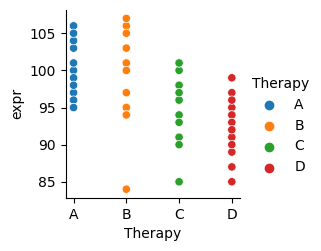

In [63]:
#Выполнение разведочного анализа EDA. Визуализация данных.
sns.pairplot(data, x_vars=["Therapy"], y_vars="expr", hue = "Therapy")

In [93]:
#Проведение теста Тьюки. Способ 1
def ssdev(xs):
  avg = xs.mean()#Среднее значение
  square_deviation = lambda x: (x - avg) ** 2
  return sum( map(square_deviation, xs)) # Проходи по всем элементам и находим сумму для значений функции.

# отклонения значений в внутри группы от средней группы
ssw = sum(data.groupby('Therapy').apply(lambda g: ssdev(np.array(g))))#Сумма квадратов разности значения и среднего, в зависимости от группы(терапии). Выходное значение array([1302.26666667])
#Количество "столбцов" или количество уникальных значений в стоблце Therapy
n = len(data.Therapy.unique())
dfw = len(data.expr) - n #Общее количество элементов(60) вычитаем количество уникальных значений по столбцу Therapy(количество столбцов)Выходное значение 56
# внутригрупповой средний квадрат
mssw = ssw/dfw #array([23.2547619])
#Стандартная ошибка
se = math.sqrt(mssw/15)#1.2451174484029452
#Перебор комбинаций ('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')
combinations = list(itertools.combinations(data.Therapy.unique(), 2))
alfa = 0.05
#Studentized Range Distribution. Расчёт q-критерия, где альфа - уровень значимости, n - кол-во групп, dfw - (общее число наблюдений - кол-во групп)
q_crit = stats.studentized_range.ppf(1-alfa, n, dfw)# 3.744678186817406
#Систематизируем полученные данные в виде таблицы
vis = pd.DataFrame(columns=[f'{first} - {second}' for first, second in combinations], index=['q','meandiff', 'p-adj', 'lower', 'upper'])
#Находим среднее значение по каждой группе
means = data.groupby('Therapy').mean().T#Транспонируем таблицу
for first, second in combinations:
  key = f'{first} - {second}'
  first_second_mean = [means[first].expr, means[second].expr]
  q = (max(first_second_mean) - min(first_second_mean))/se #Расчёт q-критерия
  meandiff = (means[second].expr - means[first].expr)
  vis[key]['q'] = q
  vis[key]['meandiff'] = meandiff
  vis[key]['p-adj'] = 1 - stats.studentized_range.cdf(q, n, dfw)
  vis[key]['lower'] = meandiff-(q_crit * se)
  vis[key]['upper'] = meandiff+(q_crit * se)
vis.T#Транспонируем

,q,meandiff,p-adj,lower,upper
A - B,0.749595,-0.933333,0.95142,-5.595897,3.729231
A - C,4.283398,-5.333333,0.018886,-9.995897,-0.670769
A - D,5.943214,-7.4,0.000542,-12.062564,-2.737436
B - C,3.533803,-4.4,0.071041,-9.062564,0.262564
B - D,5.19362,-6.466667,0.002944,-11.129231,-1.804103
C - D,1.659817,-2.066667,0.645794,-6.729231,2.595897


In [107]:
#Проведение теста Тьюки. Способ 2
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

data_stepik = pd.read_csv('https://stepik.org/media/attachments/lesson/8083/genetherapy.csv')

MultiComp = MultiComparison(data_stepik['expr'], data_stepik['Therapy'])

print(MultiComp.tukeyhsd().summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -0.9333 0.9514  -5.5959  3.7292  False
     A      C  -5.3333 0.0189  -9.9959 -0.6708   True
     A      D     -7.4 0.0005 -12.0626 -2.7374   True
     B      C     -4.4  0.071  -9.0626  0.2626  False
     B      D  -6.4667 0.0029 -11.1292 -1.8041   True
     C      D  -2.0667 0.6458  -6.7292  2.5959  False
-----------------------------------------------------


Text(0.5, 1.0, '95% family-wise confidence level')

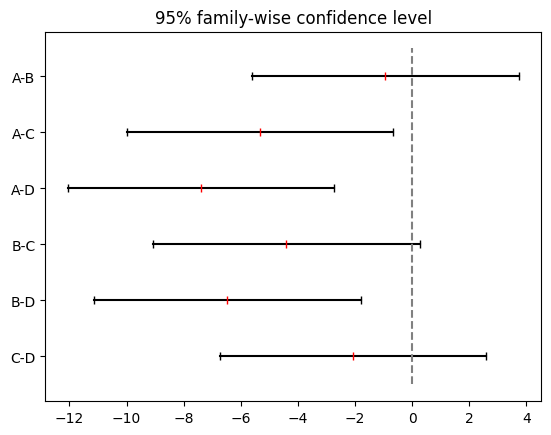

In [106]:
data = MultiComp.tukeyhsd()._results_table.data
df = pd.DataFrame(data[1:], columns=data[0])

df['category'] = df['group1'] + ['-'] * len(df) + df['group2']
df['orderby'] = range(len(df), 0, -1)

for lower, upper, meandiff, y in zip(df['lower'], df['upper'], df['meandiff'], df['orderby']):
    plt.plot((lower, upper),(y, y), '|-', color='black')#Построение прямых значений
    plt.plot(meandiff, y ,'|-', color='red')#Нанесение отметки о середине доверительного интервала

plt.yticks(df['orderby'], df['category']) #Подпись категорий слева
plt.vlines(0, df['orderby'].min() - 0.5, df['orderby'].max() + 0.5, linestyles='dashed', color='gray')
plt.title('95% family-wise confidence level')




**Заключение**
 Группы A-C, A-D, B-D значимо отличаются между собой, что позволяет отклонить нулевую гипотезу о равенстве средних. Наибольшее различие наблюдается между A и D тестами, что подтверждает q = 5.943, при q критерии = 3.744.